scrapy，爬虫工程化，对爬虫的功能进行模块化的开发，并达到批量生产的效果，其内部是协程，效率很快。

# 之前的爬虫逻辑

之前写爬虫的逻辑是先请求主页面
- 如果主页面中可以拿到想要的数据可以直接存储，如中国票房。
- 如果数据不在主页面，需要访问主页面中的url跳转到有数据的页面，我们就需要发起两次请求，才能拿到想要的数据，如爬取明朝那些事。
- 如果从主页面要多层跳转才能拿到数据，就需要发起更多次的请求。

之前编写爬虫的逻辑图

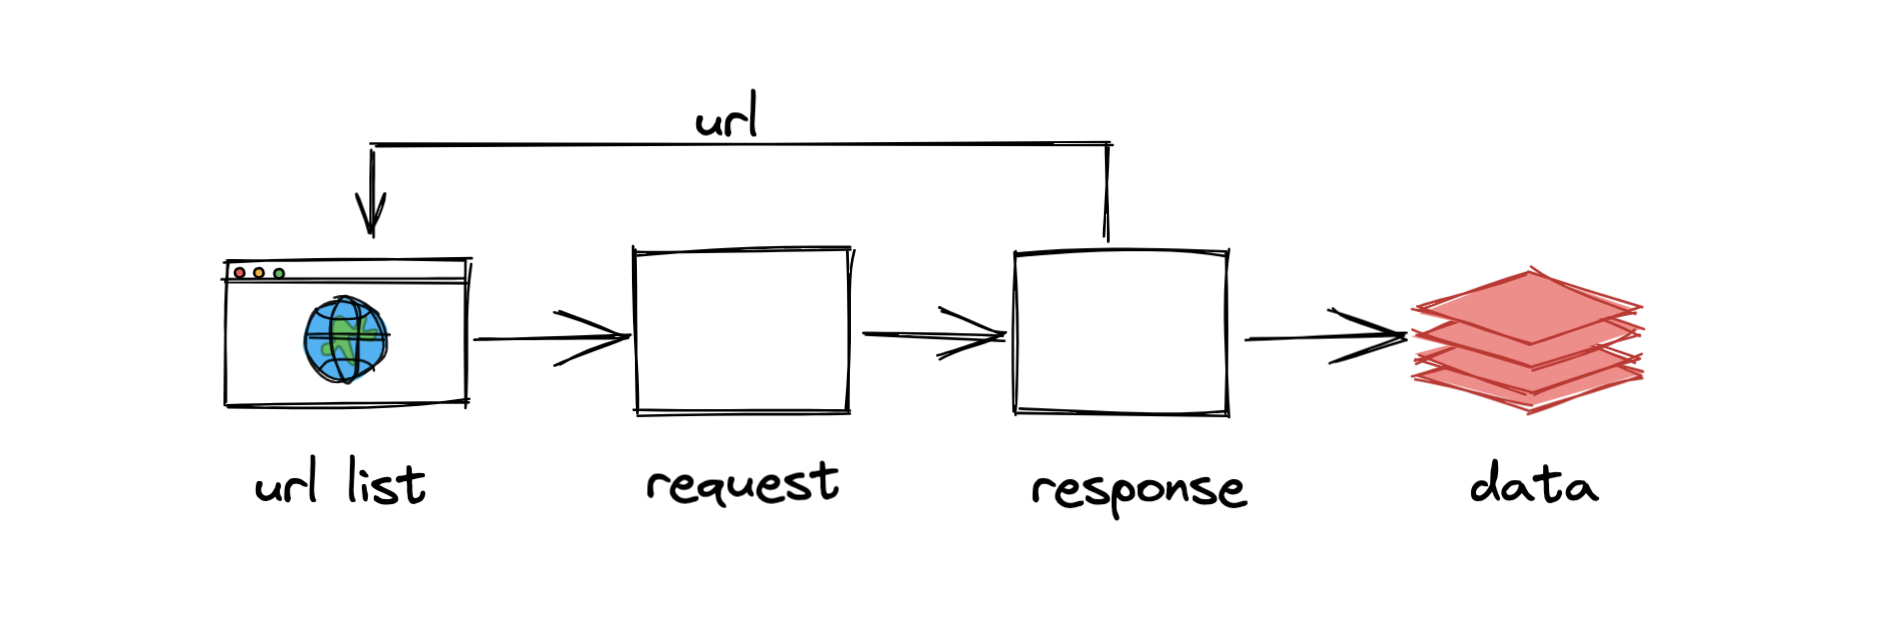

# scrapy的工作流程

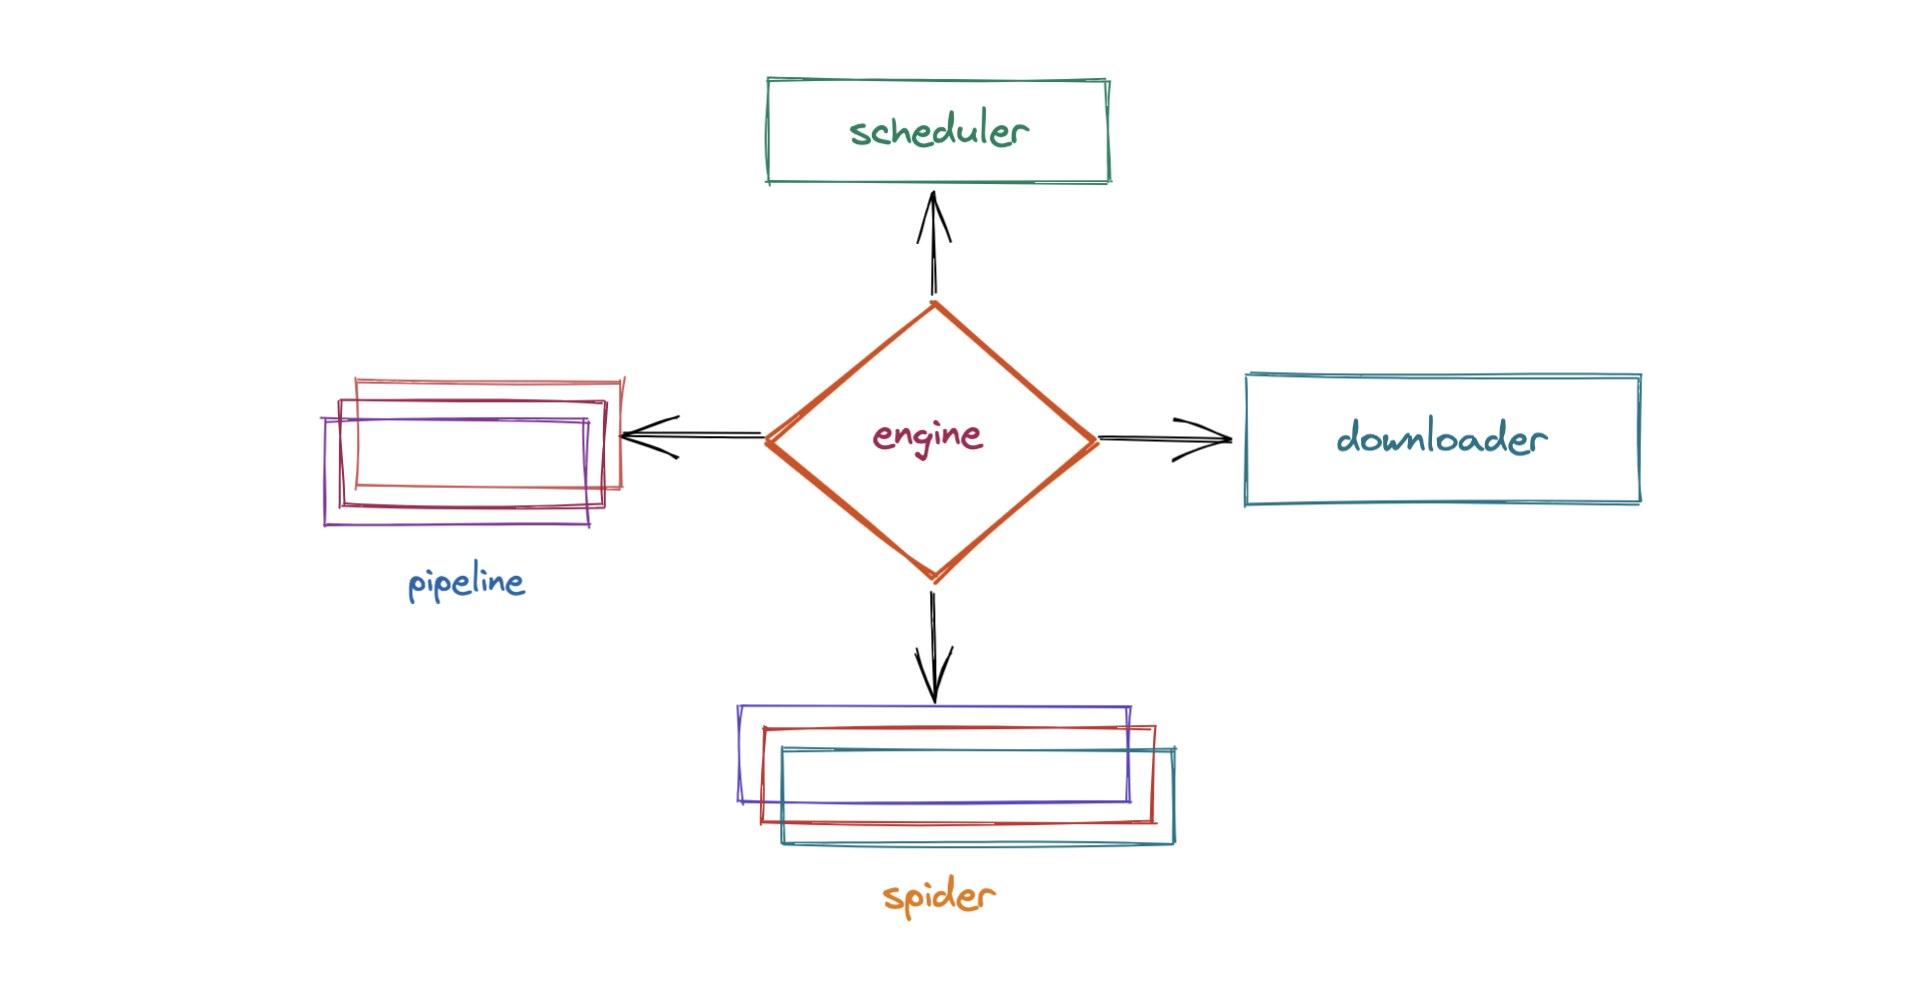

具体流程：
1. 爬虫的起始url是在spider中，会构造成Request对象，传递给调度器
2. engine 从调度器(scheduler)的队列(可以看成为一个队列)中获取一个Request对象，然后交给下载器（downloader）
3. 下载器获取页面源代码，然后封装成Response对象，反馈给engine
4. 引擎将Response对象传递给爬虫(spider)，由爬虫来对数据进行解析，并反馈给engine
5. 引擎对spider反馈的数据进行判断，是数据就将数据对象传递给pipline进行数据持久化保存或进一步的数据处理
6. 如果spider提取到的是子页面的url，将其封装为Request对象，反馈给调度器，engine将Request对象传递给scheduler，scheduler对Requst进行是否重复的
    判断，如果重复就过，如果不重复就加入，进而重复步骤2

各个模块的主要工作：
1. 引擎(engine)

   scrapy的核心, 所有模块的衔接, 数据流程梳理.

2. 调度器(scheduler)

   本质上这东西可以看成是一个集合和队列. 里面存放着一堆我们即将要发送的请求. 可以看成是一个url的容器. 它决定了下一步要去爬取哪一个url. 通常我们在这里可以对url进行去重操作.  

3. 下载器(downloader)

   它的本质就是用来发动请求的一个模块. 小白们完全可以把它理解成是一个requests.get()的功能. 只不过这货返回的是一个response对象. 

4. 爬虫(spider)

   这是我们要写的第一个部分的内容, 负责解析下载器返回的response对象.从中提取到我们需要的数据. 

5. 管道(pipeline)

   这是我们要写的第二个部分的内容, 主要负责数据的存储和各种持久化操作. 

# 简单使用

## 安装

在安装时要参考scrapy-redis的版本来选择scrapy的版本：scrapy 2.5.1  -> scrapy-redis（0.7.2）。因为scrapy升级了，scrapy-redis没有跟上升级的速度，最新版的scrapy会无法正常使用scrapy-redis。

pip install scrapy==2.5.1

检查scrapy的依赖，可能会报openssl的问题，是因为其版本过高,只要降低cryptography的版本，openssl的版本就降下来。
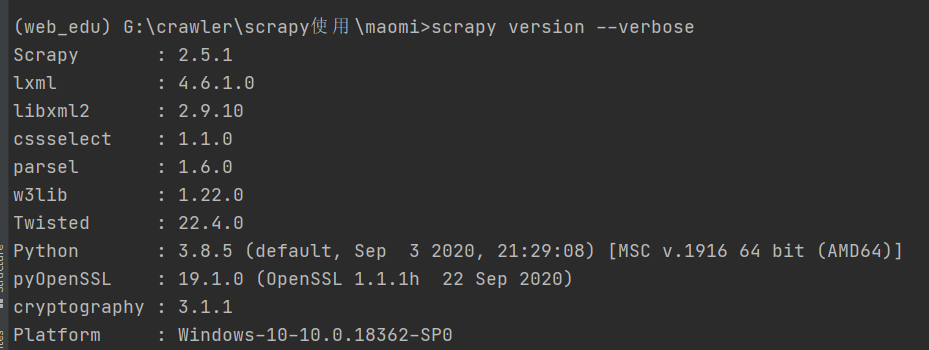

降低版本
```
pip uninstall cryptography
pip install cryptography==xxx.xx.
```

## scrapy 实例

创建项目

`scrapy startproject 项目名称`

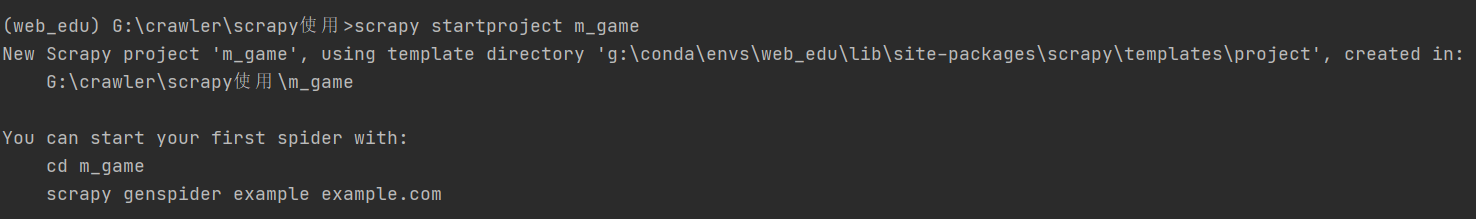

项目的目录结构

```
m_game   # 项目所在文件夹, 建议用pycharm打开该文件夹
    ├── m_game  		# 项目跟目录
    │   ├── __init__.py
    │   ├── items.py  		# 封装数据的格式
    │   ├── middlewares.py  # 所有中间件
    │   ├── pipelines.py	# 所有的管道
    │   ├── settings.py		# 爬虫配置信息
    │   └── spiders			# 爬虫文件夹, 稍后里面会写入爬虫代码
    │       └── __init__.py
    └── scrapy.cfg			# scrapy项目配置信息,不要删它,别动它,善待它. 
```

创建爬虫

爬取的网址：http://www.4399.com/flash/game100.htm
```
cd m_game
scrapy genspider youxi4399 4399.com    # scrapy genspider 爬虫名称 允许抓取的域名范围
```

如果不清楚一个网站的域名，可以在网上查询，`https://desk.zol.com.cn/dongman/ 网址中的desk.zol.com.cn内容`
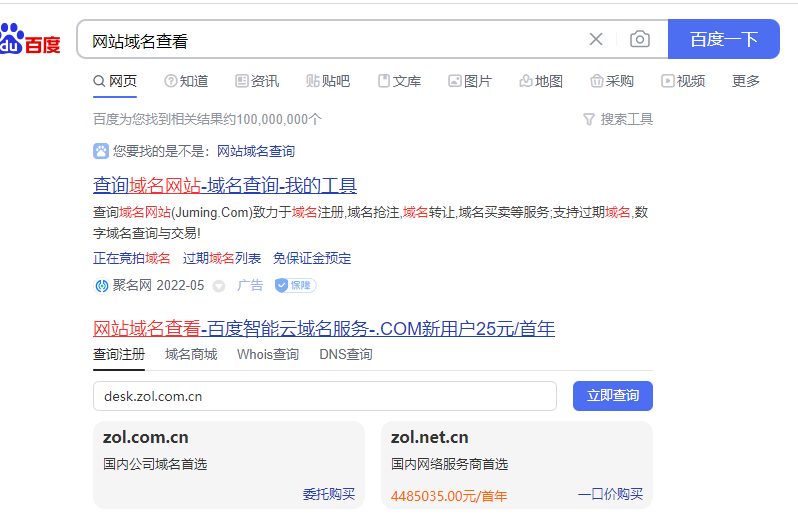

编写爬虫
```python
import scrapy


class Youxi4399Spider(scrapy.Spider):
    name = 'youxi4399'  # spider的名字
    allowed_domains = ['4399.com']  # 限制该spider抓取的域名, 只要不符合该域名的一概过掉
    start_urls = ['http://www.4399.com/flash/game100.htm']  # 起始url, 在引擎开始工作的时候. 自动的包装成一个请求对象

    def parse(self, resp, **kwargs):
        # 解析start_urls返回的响应
        print(resp.text)

```

启动爬虫: `scrapy crawl youxi4399  # youxi4399是爬虫名字`

启动后默认会打印scrapy执行的日志，因为默认其日志级别默认是INFO，如果不想看到可以在settins.py中设置日志级别
```python
# 配置日志级别
LOG_LEVEL = "WARNING"    # 最大限度的保留错误信息. 而又不会被一些乱七八糟的日志影响
# CRITICAL50=> 非常非常严重的错误. 解析器级别的
# ERROR   40=>  报错, 程序挂了
# WARNING 30=>  警告, 过时警告, 不会影响程序的执行.
# INFO    20=>  一些提示信息, print("下载成功")
# DEBUG   10=>  碎嘴子. 啥玩意都记录

# Obey robots.txt rules
# ROBOTS: 君子协议
ROBOTSTXT_OBEY = False
```

以前解析数据的做法
```
from lxml import etree
tree = etree.HTML(resp.text)
tree.xpath("xxx")
```

爬虫代码完善
```python
# m_game/m_game/spiders/youxi4399.py
import scrapy


class Youxi4399Spider(scrapy.Spider):
    name = 'youxi4399'  # spider的名字
    allowed_domains = ['4399.com']  # 限制该spider抓取的域名, 只要不符合该域名的一概过掉
    start_urls = ['http://www.4399.com/flash/game100.htm']  # 起始url, 在引擎开始工作的时候. 自动的包装成一个请求对象

    def parse(self, resp, **kwargs):
        # 解析start_urls返回的响应
        li_list = resp.xpath("//*[@id='list']/li")  # 拿到的是Selector对象
        # extract_first()  提取第一个, 它的好处是. 不会越界. 如果没有东西. 这里获取到的是None
        # li_list = resp.xpath("//*[@id='list']/li").extract()  # 拿到所有的数据
        for li in li_list:
            name = li.xpath("./div[1]/a//text()").extract_first()
            category = li.xpath("./span[1]/a/text()").extract_first()
            pub_time = li.xpath("./span[2]/text()").extract_first()
            # yield 返回的内容只能是：
            #   - 字典 item  是数据，传递到pipline保存数据
            #   - Request对象，需要继续请求，保存到调度器
            yield {"name": name, "category": category, "pub_time": pub_time}  # 给引擎返回数据


```


pipline的使用要在settings.py文件中进行设置：
```
ITEM_PIPELINES = {
   # 后面是优先级, 优先级月低越先执行, 前面是pipeline的类名地址
   'm_game.pipelines.MGamePipeline': 300,
}
```

pipline的代码
```
# m_game/m_game/pipelines.py
from itemadapter import ItemAdapter


class MGamePipeline:
    # 这个方法的声明不能动!!! 在spider返回的数据会自动的调用这里的process_item方法. 
    def process_item(self, item, spider):
        print("我是pipline",item)
        return item

```

输出结果：
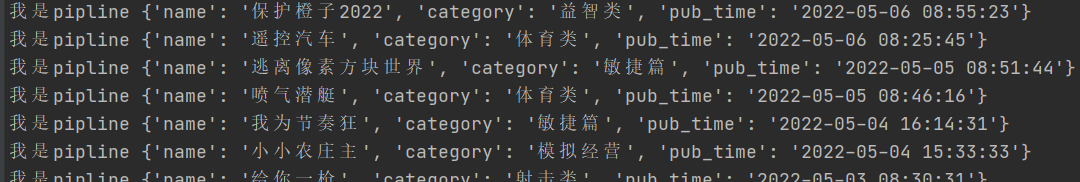

# item 封装传递的数据格式

在spider的parse中，可以使用字典和item作为数据的传递格式，这两者看个人喜好选择。

使用字典的时候，传递数据的key是在yield的时候设置的，存储数据是在管道中，可能获取数据时输入的key和传递数据时的key不一致，导致获取不到数据，会有不易察觉的错误。

官方推荐使用item来限定数据的key，其用法大部分和字典一样，其作用仅仅是约束数据的格式。

## 实例

网址：https://match.lottery.sina.com.cn/lotto/pc_zst/index?lottoType=ssq&actionType=chzs

在items.py中约束数据格式：
```python
import scrapy


class CaiItem(scrapy.Item):
    # define the fields for your item here like:
    # name = scrapy.Field()
    pub_time = scrapy.Field()  # 固定写法
    red_ball = scrapy.Field()
    blue_ball = scrapy.Field()
```

编写爬虫：

```python
import scrapy
from cai.items import CaiItem

class SsqSpider(scrapy.Spider):
    name = 'ssq'
    allowed_domains = ['sina.com.cn']
    start_urls = ['https://match.lottery.sina.com.cn/lotto/pc_zst/index?lottoType=ssq&actionType=chzs']

    def parse(self, resp, **kwargs):
        # print(resp.text)
        trs = resp.xpath("//*[@id='cpdata']/tr")
        for tr in trs:
            # print(trs)
            pub_time = tr.xpath("./td[1]/text()").extract_first()
            red_ball = tr.xpath("./td[@class='chartball01' or @class='chartball02']/text()").extract()
            blue_ball = tr.xpath("./td[@class='chartball02']/text()").extract_first()
            # print(pub_time, red_ball, blue_ball)
            if not red_ball:  # 去掉空值
                continue
            cai = CaiItem()
            cai['pub_time'] = pub_time
            cai['red_ball'] = red_ball
            cai['blue_ball'] = blue_ball
            yield cai




```

在导入CaiItem时，pycharm可能会误报路径问题
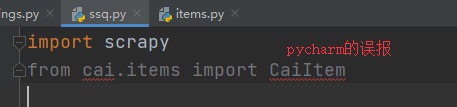
解决方法：
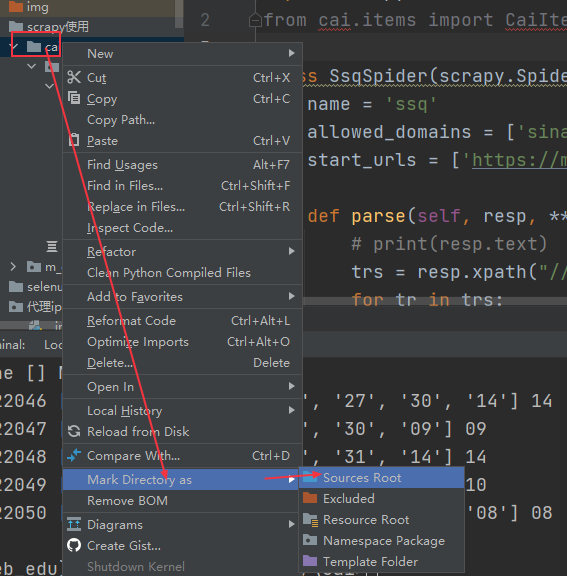

# 管道，永久化存储

当数据以item对象的形式传递到管道时，对其数据进行存储。

继续以item中的实例代码进行编写

## csv文件写入

首先介绍管道中的两个方法：
- open_spider(), 在爬虫开始的时候执行一次
- close_spider(), 在爬虫结束的时候执行一次

编写管道代码：
```python
# Define your item pipelines here
#
# Don't forget to add your pipeline to the ITEM_PIPELINES setting
# See: https://docs.scrapy.org/en/latest/topics/item-pipeline.html


# useful for handling different item types with a single interface
from itemadapter import ItemAdapter


class CaiPipeline:
    # 仅限于pipeline固定的写法.
    # open_spider, 爬虫在开始的时候执行，意思是执行scrapy crawl ssq开始时执行此方法
    def open_spider(self, spider):
        # print(spider.name)  # spider是爬虫对象，通过spider.name查看爬虫的名字
        self.f = open('caipiao.csv', mode='w', encoding='utf-8')

    # 爬虫结束的时候执行
    def close_spider(self, spider):
        if self.f:
            self.f.close()
        # print(spider.name)

    # spider每次返回一条数据. 这里都会自动的执行一次process_item，数据以参数的形式传递过来: item
    def process_item(self, item, spider):
        # print(item)
        self.f.write(item['pub_time'])
        self.f.write(",")
        self.f.write("_".join(item['red_ball']))  # 注意，red_ball是一个列表
        self.f.write(",")
        self.f.write(item['blue_ball'])
        self.f.write("\n")
        return item  # return在process_item中的逻辑, 是将数据传递给一下管道

```


## mysql数据库写入

会存在多个管道，每个管道的存储方式都不相同，多个管道的数据流向如下图：
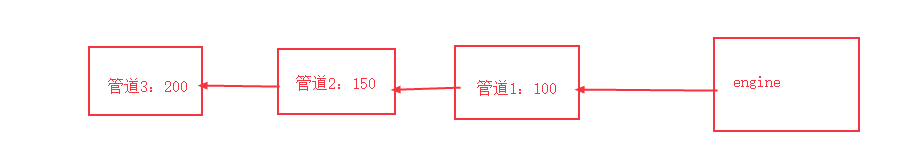

在管道的process_item方法中return的值会传递到下一个管道中，传递的顺序根据settings.py文件中的`ITEM_PIPELINES`决定，其后的数字越小其优先级越高，会优先将数据流向给优先级大的管道。

也有一种说法是距离egine越近的管道会先传递。



piplines.py文件中新增一个管道
```python
# piplines.py文件中新增一个管道
class MySQLPipeline:
    def open_spider(self, spider_name):
        # 连接mysql
        self.conn = pymysql.connect(
            host="127.0.0.1",
            port=3306,
            database="cai",
            user="root",
            password="root"
        )

    def close_spider(self, spider_name):
        self.conn.close()

    def process_item(self, item, spider):
        # 存储数据
        try:  # 代码调试期间. 可以考虑不添加try...except...为了能看到更加完整的错误信息
            cur = self.conn.cursor()
            qi = item['pub_time']
            # red_ball = "_".join(item['red_ball'])
            red_ball = item['red_ball']
            blue_ball = item['blue_ball']
            sql = f"insert into ssq(pub_time, red_ball, blue_ball) values ('{pub_time}', \"{red_ball}\", '{blue_ball}')"
            cur.execute(sql)
            self.conn.commit()
        except Exception as e:
            print(e)
            if cur:
                cur.close()
            self.conn.rollback()
        return item
```

settings.py文件中配置管道，设置优先级
```python
ITEM_PIPELINES = {
   'cai.pipelines.CaiPipeline': 300,
   'cai.pipelines.MySQLPipeline': 301,
}
```

## mongoDB 和 redis

按照文件和mysql的格式写就行了，都是固定格式。

mongoDB
```python
class MongoPipeline:
    def open_spider(self, spider_name):
        self.conn = pymongo.MongoClient(
            host="127.0.0.1",
            port=27017
        )
        self.db = self.conn['python']

    def close_spider(self, spider_name):
        self.conn.close()

    def process_item(self, item, spider):
        # print("mongo===>", item)
        self.db.ssq.insert_one({"pub_time": item['pub_time'], "red_ball": item['red_ball'], "blue_ball": item['blue_ball']})
        return item  # 给到下一个管道
```

redis
```python
```

## 图片数据的存储

网址：https://desk.zol.com.cn/dongman/

思路分析：

之前scrapy爬去的网站都是一层的，直接在主页面能拿到数据，这个网址上的数据在子页面的中，也就是说，这个页面需要downloader下载多次。

而且这个网站需要设置头信息：user-agent，在settings.py文件中设置
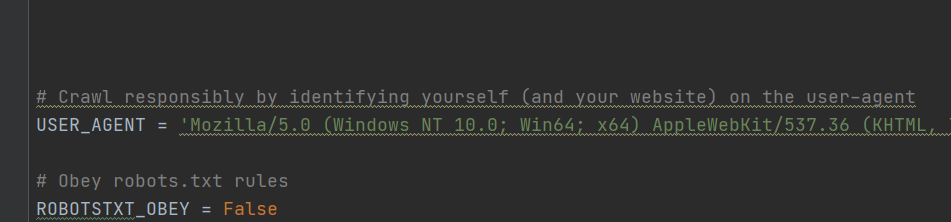


使用scrapy的图片存储时，必须在settings.py中设置一个总的图片存储文件夹：
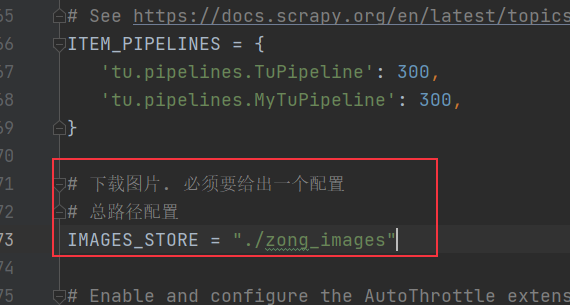

代码实现：

目录结构
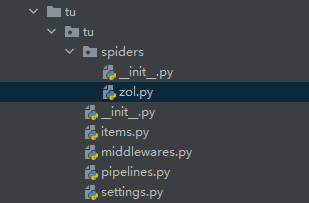

爬虫代码：
```python
import scrapy
from urllib.parse import urljoin

class ZolSpider(scrapy.Spider):
    name = 'zol'
    allowed_domains = ['zol.com.cn']
    start_urls = ['https://desk.zol.com.cn/dongman/']

    def parse_detail(self, resp, **kwargs):
        # 仿照这parse写，parse是start_urls指定的解析方法，此函数是callback中指定的方式
        # 在这里得到的响应就是url=href返回的响应
        # print(resp)
        img_src = resp.xpath("//*[@id='bigImg']/@src").extract_first()
        yield {'img_src': img_src}


    def parse(self, resp, **kwargs):
        # print(resp.text)

        li_list = resp.xpath("//*[@class='pic-list2  clearfix']/li")
        for li in li_list:
            href = li.xpath(".//a/@href").extract_first()
            if not href.endswith('html'):
                continue
            # print(href)  # 此时拿到的url是不完整的，需要拼接，/bizhi/9109_111583_2.html
            # 常规的拼接操作
            # href = urljoin(resp.url, href)  # resp.url   当前这个响应是请求的哪个url回来的.
            # print(href)

            # scrapy提供了更简便的方式来拼接
            href = resp.urljoin(href)
            # print(href)

            # 请求到详情页，拿到图片的下载地址
            yield scrapy.Request(
                url=href,
                method="get",
                callback=self.parse_detail,  # 当前url返回之后.自动执行的那个解析函数
            )

```

管道代码
```python
# Define your item pipelines here
#
# Don't forget to add your pipeline to the ITEM_PIPELINES setting
# See: https://docs.scrapy.org/en/latest/topics/item-pipeline.html


# useful for handling different item types with a single interface
from itemadapter import ItemAdapter
import scrapy
# ImagesPipeline 图片专用的管道
from scrapy.pipelines.images import ImagesPipeline

class TuPipeline:
    def process_item(self, item, spider):
        print(item['img_src'])
        # 一个存储方案. 比较好的一个方式，scrapy中的图片为了速度，将下面三行代码拆分了
        # import requests
        # resp = requests.get(img_src)
        # resp.content
        return item


# scrapy的方案
class MyTuPipeline(ImagesPipeline):
    # 1. 发送请求(下载图片, 文件, 视频,xxx)
    def get_media_requests(self, item, info):
        url = item['img_src']
        yield scrapy.Request(url=url, meta={"sss": url})  # 直接返回一个请求对象即可

    # 2. 图片的存储路径
    # 完整的路径: IMAGES_STORE + file_path()的返回值
    # 在这个过程中. 文件夹自动创建
    def file_path(self, request, response=None, info=None, *, item=None):
        # 可以准备文件夹
        img_path = "dongman/imgs/i1/i2"
        # 准备文件名字
        # 坑: response.url 没办法正常使用
        # file_name = response.url.split("/")[-1]  # 直接用响应对象拿到url,是同时执行的，此函数执行时，response可能还没有回来
        # print("response:", file_name)
        file_name = item['img_src'].split("/")[-1]  # 用item拿到url
        print("item:", file_name)
        file_name = request.meta['sss'].split("/")[-1]
        print("meta:", file_name)

        real_path = img_path + "/" + file_name  # 文件夹路径拼接
        return real_path  # 返回文件存储路径即可

    # 3. 可能需要对item进行更新
    def item_completed(self, results, item, info):
        # print(results)
        for r in results:
            print(r[1]['path'])
        return item  # 一定要return item 把数据传递给下一个管道
```

settings.py
```python

BOT_NAME = 'tu'

SPIDER_MODULES = ['tu.spiders']
NEWSPIDER_MODULE = 'tu.spiders'
LOG_LEVEL = 'WARNING'


# Crawl responsibly by identifying yourself (and your website) on the user-agent
USER_AGENT = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36"

# Obey robots.txt rules
ROBOTSTXT_OBEY = False

ITEM_PIPELINES = {
   'tu.pipelines.TuPipeline': 300,
   'tu.pipelines.MyTuPipeline': 300,
}

# 下载图片. 必须要给出一个配置
# 总路径配置
IMAGES_STORE = "./zong_images"

```

最终爬取结果

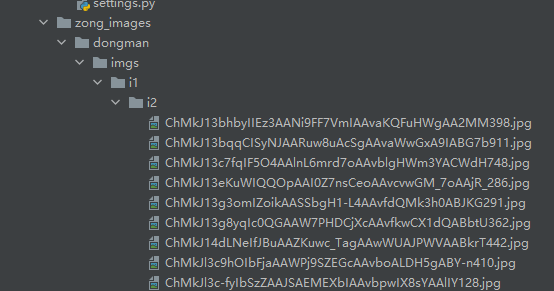

tips: 在保存图片的过程中可能会遇到下图的问题
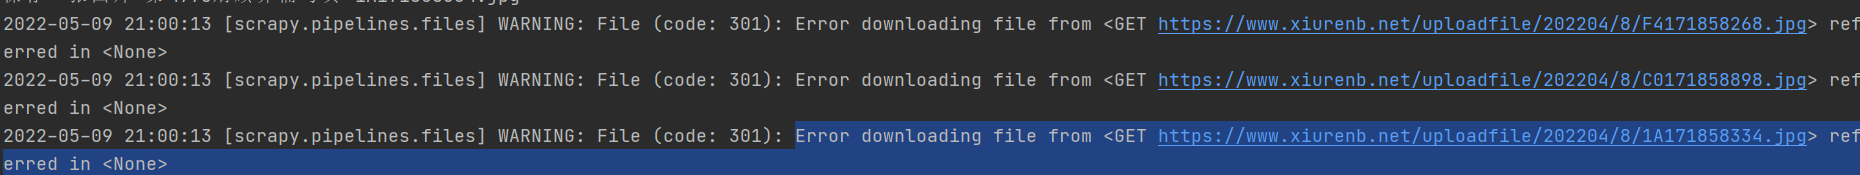
解决方法是，在setitngs.py配置`MEDIA_ALLOW_REDIRECTS = True`

# scrapy模拟登录

多数网页在你成功登录之后会生成cookie，用户下次操作携带cookie之后就不用再次输入密码了，保存了用户的登录状态，网页多数根据请求头中cookie信息来判断是否已经登录。

需求：获取17k的书架上书籍信息，网址：https://user.17k.com/www/bookshelf/
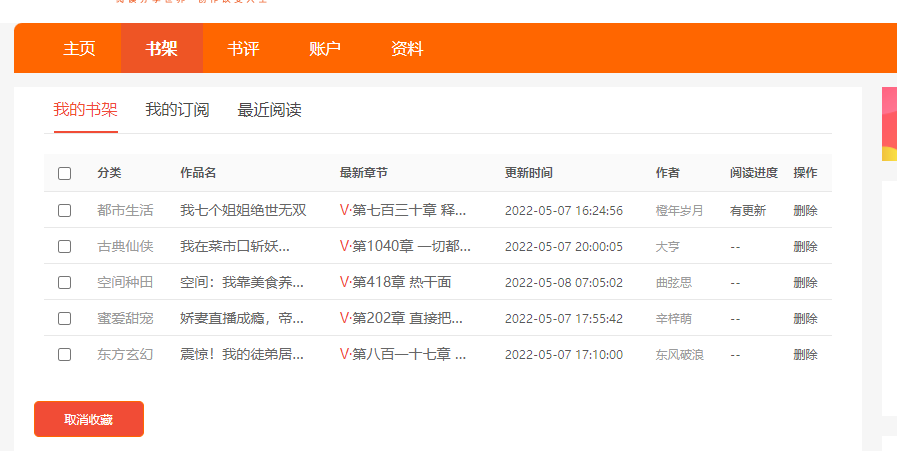

分析网页的数据是在哪的：

- 打开网页源代码，搜索书架上的作品名，发现没有想要的数据
- 数据不在源代码中，去抓包，看数据是哪个请求携带的
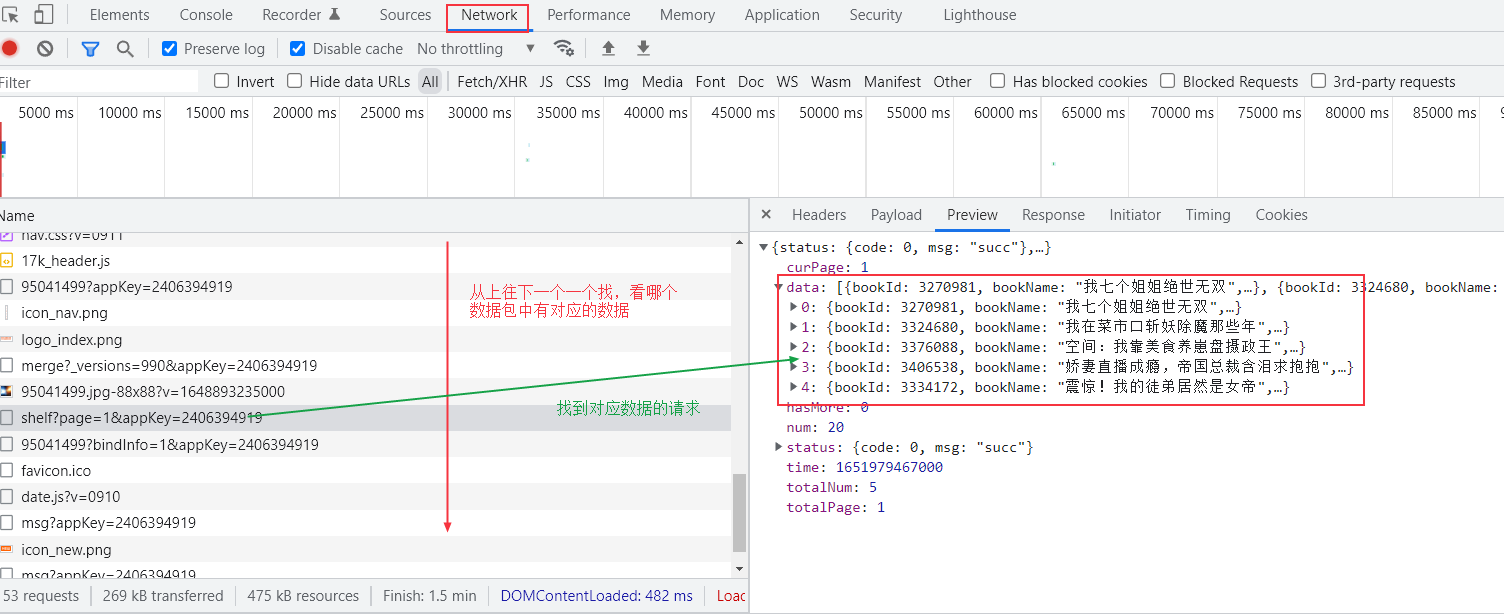
- 找到了携带对应数据的数据包，模拟发送该请求获取数据

## 暴力拷贝网页上的cookie

在网页登录后，直接从网打开F12将cookie拷贝出来直接使用。
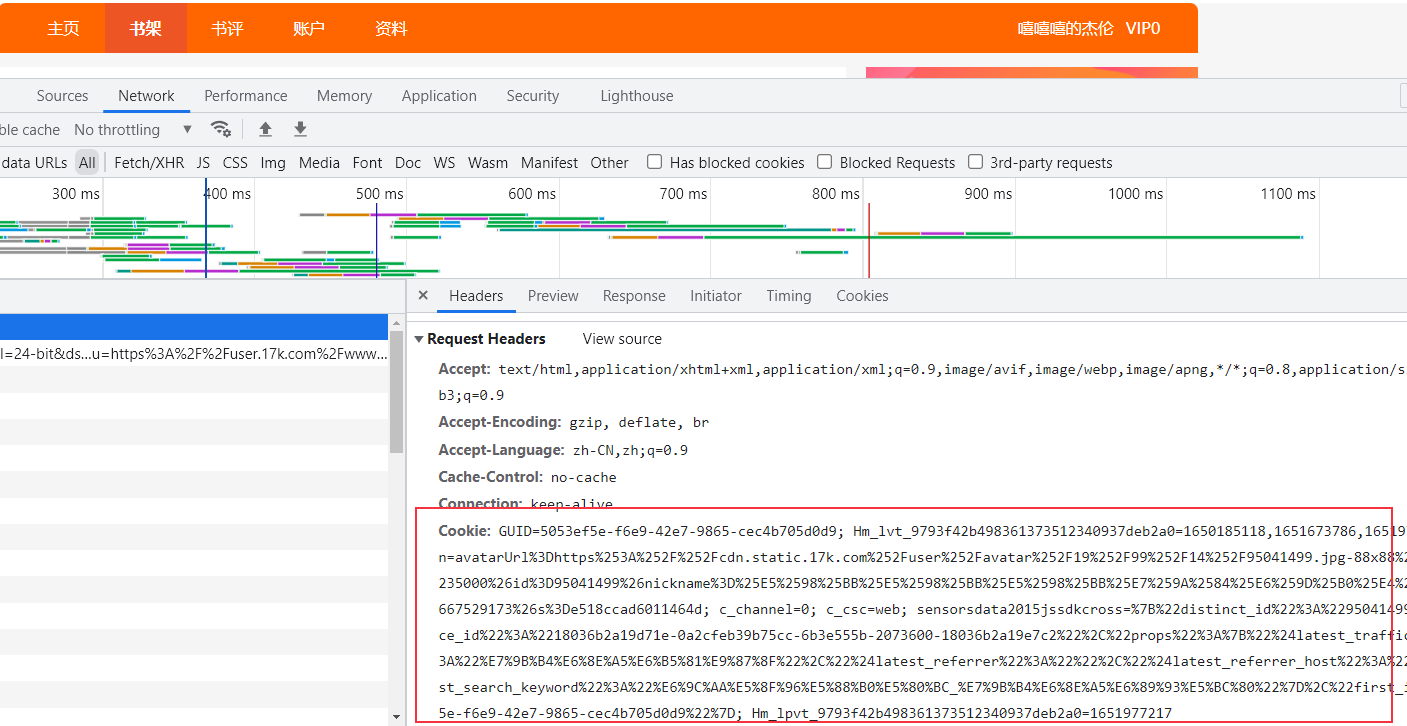


- 生成项目 `scrapy startproject xiaoshuo`
- 创建爬虫 `scrapy genspider login 17k.com`

### settings.py文件配置cookie

**1.在settings.py 中设置请求头信息**

```python
BOT_NAME = 'xiaoshuo'

SPIDER_MODULES = ['xiaoshuo.spiders']
NEWSPIDER_MODULE = 'xiaoshuo.spiders'
LOG_LEVEL = 'WARNING'


# Crawl responsibly by identifying yourself (and your website) on the user-agent
USER_AGENT = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36"

# Obey robots.txt rules
ROBOTSTXT_OBEY = False


# Override the default request headers:
DEFAULT_REQUEST_HEADERS = {  # 打开这里的注释，在这里添加cookie的信息
  'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
  'Accept-Language': 'en',
  'Cookie': 'GUID=5053ef5e-f6e9-42e7-9865-cec4b705d0d9; Hm_lvt_9793f42b498361373512340937deb2a0=1650185118,1651673786,1651976106; accessToken=avatarUrl%3Dhttps%253A%252F%252Fcdn.static.17k.com%252Fuser%252Favatar%252F19%252F99%252F14%252F95041499.jpg-88x88%253Fv%253D1648893235000%26id%3D95041499%26nickname%3D%25E5%2598%25BB%25E5%2598%25BB%25E5%2598%25BB%25E7%259A%2584%25E6%259D%25B0%25E4%25BC%25A6%26e%3D1667529173%26s%3De518ccad6011464d; c_channel=0; c_csc=web; sensorsdata2015jssdkcross=%7B%22distinct_id%22%3A%2295041499%22%2C%22%24device_id%22%3A%2218036b2a19d71e-0a2cfeb39b75cc-6b3e555b-2073600-18036b2a19e7c2%22%2C%22props%22%3A%7B%22%24latest_traffic_source_type%22%3A%22%E7%9B%B4%E6%8E%A5%E6%B5%81%E9%87%8F%22%2C%22%24latest_referrer%22%3A%22%22%2C%22%24latest_referrer_host%22%3A%22%22%2C%22%24latest_search_keyword%22%3A%22%E6%9C%AA%E5%8F%96%E5%88%B0%E5%80%BC_%E7%9B%B4%E6%8E%A5%E6%89%93%E5%BC%80%22%7D%2C%22first_id%22%3A%225053ef5e-f6e9-42e7-9865-cec4b705d0d9%22%7D; Hm_lpvt_9793f42b498361373512340937deb2a0=1651977217',
}

```

**2.修改默认生成的spider文件**

```python
# xiaoshuo/xiaoshuo/spiders/login.py
import scrapy


class LoginSpider(scrapy.Spider):
    name = 'login'
    allowed_domains = ['17k.com']
    start_urls = ['https://user.17k.com/ck/author/shelf?page=1&appKey=2406394919']  # 修改其起始url

    def parse(self, resp, **kwargs):  # 参数修改和这个一模一样
        print(resp.text)  # 打印resp对象的源代码

```

**3.启动爬虫**

`scrapy crawl login`

此时查看源代码，发现并没有拿到想要的书架信息
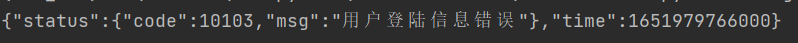

说明我们在请求头中设置的cookie是没有起效，在发送请求的时候没有携带在settings.py中设置的cookies，其原因是scrapy的cookies中间件，它会将之前的cookie信息全部删掉，所以是没有效果的，可以在settings.py文件中将scrapy的cookies中间件不启用,只要打开一行注释即可
```
COOKIES_ENABLED = False  # 关闭scrapy的cookies中间件，就不会清空之前的cookie了，永远用的是一个cookie
```

再次启动爬虫看效果：成功拿到了想要的数据
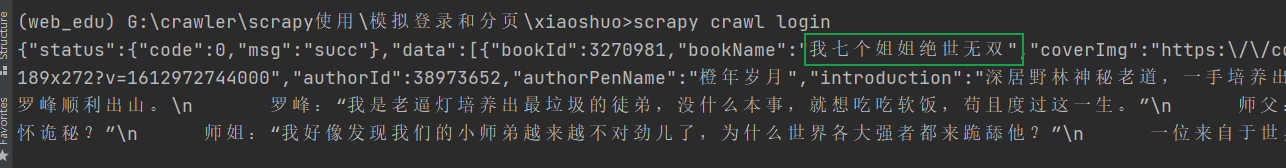

**总结**

我们关闭了scrapy的cookie中间件，其的作用是自动维护请求中的cookie。所以我们此时的方式是从开始到结束都用的是一个cookie，会有cookie过时的问题，如果访问过程中cookie更新了，我们这个程序就失效了。

此方法可以在网页都是一个cookie的情况下使用。

### 在第一次发送请求的时候添加上cookie

**1.第一个发送请求和Request设置cookie的分析**

在spider中我们会设置一个起始url：`start_urls = ['https://user.17k.com/ck/author/shelf?page=1&appKey=2406394919']`

起始的url是由scrapy自动控制发送请求的，分析代码就会发现spider是通过其继承的`scrapy.Spider`类中的start_requests来给引擎反馈第一个请求。
```python
# Spider的源码
class Spider(object_ref):
    def start_requests(self):
        cls = self.__class__
        if not self.start_urls and hasattr(self, 'start_url'):
            raise AttributeError(
                "Crawling could not start: 'start_urls' not found "
                "or empty (but found 'start_url' attribute instead, "
                "did you miss an 's'?)")
        if method_is_overridden(cls, Spider, 'make_requests_from_url'):
            warnings.warn(
                "Spider.make_requests_from_url method is deprecated; it "
                "won't be called in future Scrapy releases. Please "
                "override Spider.start_requests method instead "
                f"(see {cls.__module__}.{cls.__name__}).",
            )
            for url in self.start_urls:
                yield self.make_requests_from_url(url)
        else:
            for url in self.start_urls:  # 遍历start_urls，给引擎反馈请求对象
                yield Request(url, dont_filter=True)
```

我们继承了这个类，可以通过重写父类的**start_requests**方法，来控制第一个请求发出的逻辑，在实例化Request对象时，传递cookies参数,根据Request初始化的源码，可以分析出其cookies参数的类型是一个字典：
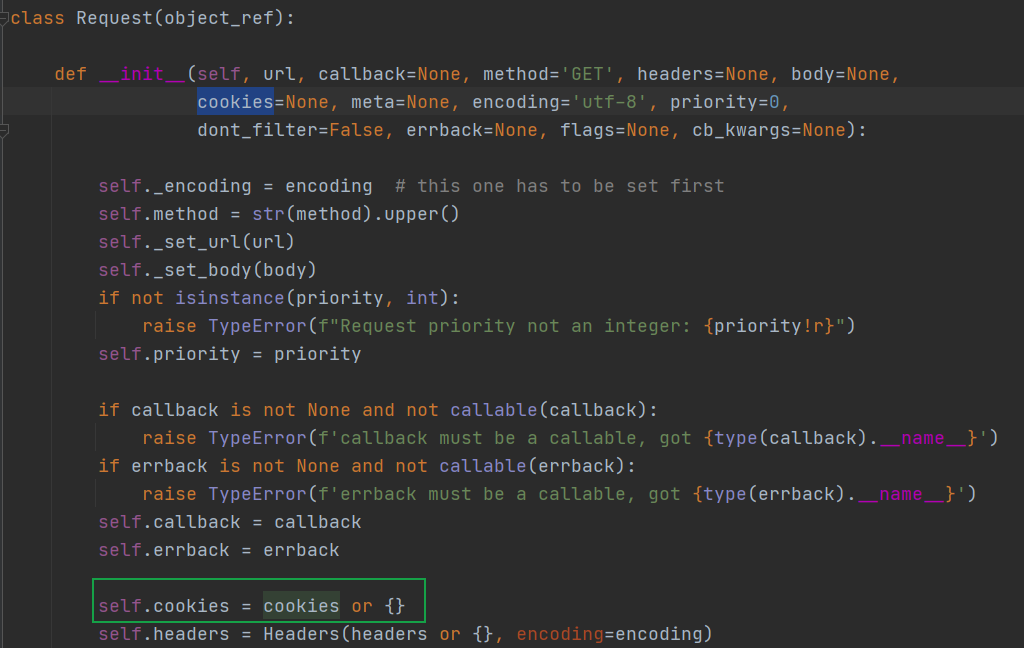

直接从网站复制过来的cookie是一个字符串，而cookies参数的值需要的是一个字典，我们需要将复制过来的cookie字符串进行分解{key：value, key:value,...}的形式。意思是cookie字符串中的`=`号两左侧的是key，右侧是value，`;`隔开了多个`key:value`。


**2.编写爬虫代码**

In [ ]:
import scrapy


class LoginSpider(scrapy.Spider):
    name = 'login'
    allowed_domains = ['17k.com']
    start_urls = ['https://user.17k.com/ck/author/shelf?page=1&appKey=2406394919']

    def start_requests(self):
        # 可以完全抄父类的方法内容，然后修改请求对象的参数。也可以如下编写
        # 1. 从网站的请求中复制的cookie
        cookie = 'GUID=5053ef5e-f6e9-42e7-9865-cec4b705d0d9; Hm_lvt_9793f42b498361373512340937deb2a0=1650185118,1651673786,1651976106; accessToken=avatarUrl%3Dhttps%253A%252F%252Fcdn.static.17k.com%252Fuser%252Favatar%252F19%252F99%252F14%252F95041499.jpg-88x88%253Fv%253D1648893235000%26id%3D95041499%26nickname%3D%25E5%2598%25BB%25E5%2598%25BB%25E5%2598%25BB%25E7%259A%2584%25E6%259D%25B0%25E4%25BC%25A6%26e%3D1667529173%26s%3De518ccad6011464d; c_channel=0; c_csc=web; sensorsdata2015jssdkcross=%7B%22distinct_id%22%3A%2295041499%22%2C%22%24device_id%22%3A%2218036b2a19d71e-0a2cfeb39b75cc-6b3e555b-2073600-18036b2a19e7c2%22%2C%22props%22%3A%7B%22%24latest_traffic_source_type%22%3A%22%E7%9B%B4%E6%8E%A5%E6%B5%81%E9%87%8F%22%2C%22%24latest_referrer%22%3A%22%22%2C%22%24latest_referrer_host%22%3A%22%22%2C%22%24latest_search_keyword%22%3A%22%E6%9C%AA%E5%8F%96%E5%88%B0%E5%80%BC_%E7%9B%B4%E6%8E%A5%E6%89%93%E5%BC%80%22%7D%2C%22first_id%22%3A%225053ef5e-f6e9-42e7-9865-cec4b705d0d9%22%7D; Hm_lpvt_9793f42b498361373512340937deb2a0=1651979466'
        # 2. 拆解cookie为字典
        cookie_dict = {}
        for item in cookie.split('; '):
            key, value = item.split('=')
            cookie_dict[key] = value
        # print(cookie_dict)
        for url in self.start_urls:
            # 3. 添加cookie参数，
            yield scrapy.Request(url, dont_filter=True, cookies=cookie_dict)

    def parse(self, resp, **kwargs):
        print(resp.text)


执行爬虫可以拿到对应的数据了。

**3.总结**

这个方式也是自始至终用的是同一个cookie，如果在parse中要在嵌套一层的请求的话，就需要和start_requests方法中一个给Requests对象手动的传递cookies参数。

也要面临cookie过期的问题，毕竟都是从网页上直接复制过来的cookie。

此方式仅适用于cookie不变的网页，但是没有在settings.py中设置cookie的方式好写。

## scrapy模拟网页登录，scrapy自动维护cookie

思路：

    分析网页的登录逻辑，重写start_requests方法，该方法做的事情是：发送登录请求。登录成功后可以，scrapy自动维护cookie，后续请求对象中就不用再手动添加cookie了。

### scrapy 发送post请求的两种方式

**方式1：**

其参数必须是body，请求体形式的参数，如下：
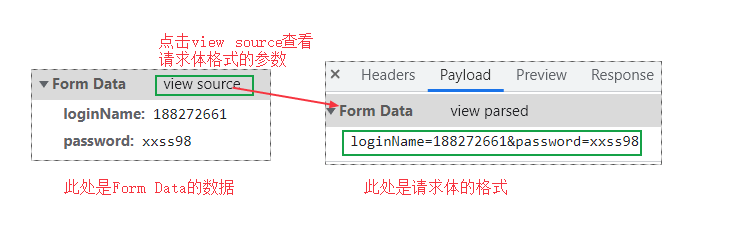

爬虫代码：
```python
import scrapy


class LoginSpider(scrapy.Spider):
    name = 'login'
    allowed_domains = ['17k.com']
    start_urls = ['https://user.17k.com/ck/author/shelf?page=1&appKey=2406394919']

    def start_requests(self):
        # 进行登录请求
        login_url = "https://passport.17k.com/ck/user/login"
        # 反馈登录请求对象给engine
        yield scrapy.Request(
            url=login_url,
            method='POST',
            body='loginName=xxxxxaccount&password=xxxxxpwd',  # POST方法的请求参数是body，请求体的格式
            callback=self.login_success  # 请求执行成功的回调
        )

    def login_success(self, resp, **kwargs):
        # 登录成功，自动维护cookie，直接反馈引擎start_urls的请对象，cookies中间件自动维护cookie
        # print(resp.text)
        # 发起第一次请求
        yield scrapy.Request(
            url=self.start_urls[0],
            method='GET',
            callback=self.parse
        )

    def parse(self, resp, **kwargs):
        # 拿到第一次请求的源代码
        print(resp.text)

```

拿到了书架的数据：
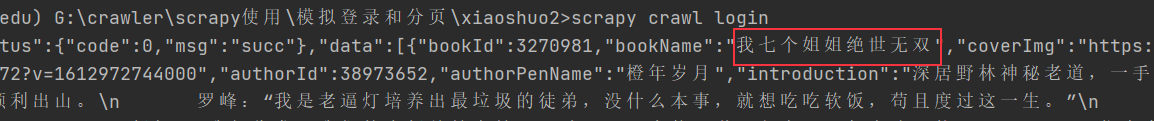

**方式2：**

使用`FormRequest`给引擎反馈请求对象，发送POST请求，其请求参数是如下格式:
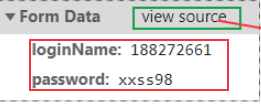

爬虫代码：
```python
import scrapy


class LoginSpider(scrapy.Spider):
    name = 'login'
    allowed_domains = ['17k.com']
    start_urls = ['https://user.17k.com/ck/author/shelf?page=1&appKey=2406394919']

    def start_requests(self):
        login_url = "https://passport.17k.com/ck/user/login"
        yield scrapy.FormRequest(
            url=login_url,
            method='POST',
            formdata={'loginName': '16538989670', 'password': 'q6035945'},  # POST请求的参数
            callback=self.login_success
        )

    def login_success(self, resp, **kwargs):
        # 登录成功，自动维护cookie，直接反馈start_urls的请求对象
        # print(resp.text)
        yield scrapy.Request(
            url=self.start_urls[0],
            method='GET',
            callback=self.parse
        )

    def parse(self, resp, **kwargs):
        print(resp.text)

```

### 总结

cookies中间件会自动维护cookie，也不用担心请求过期的请求，中间件会自动更新。

# scrapy 分页

网址: https://www.17k.com/all

需求：抓取每一页的 书名 作者 状态
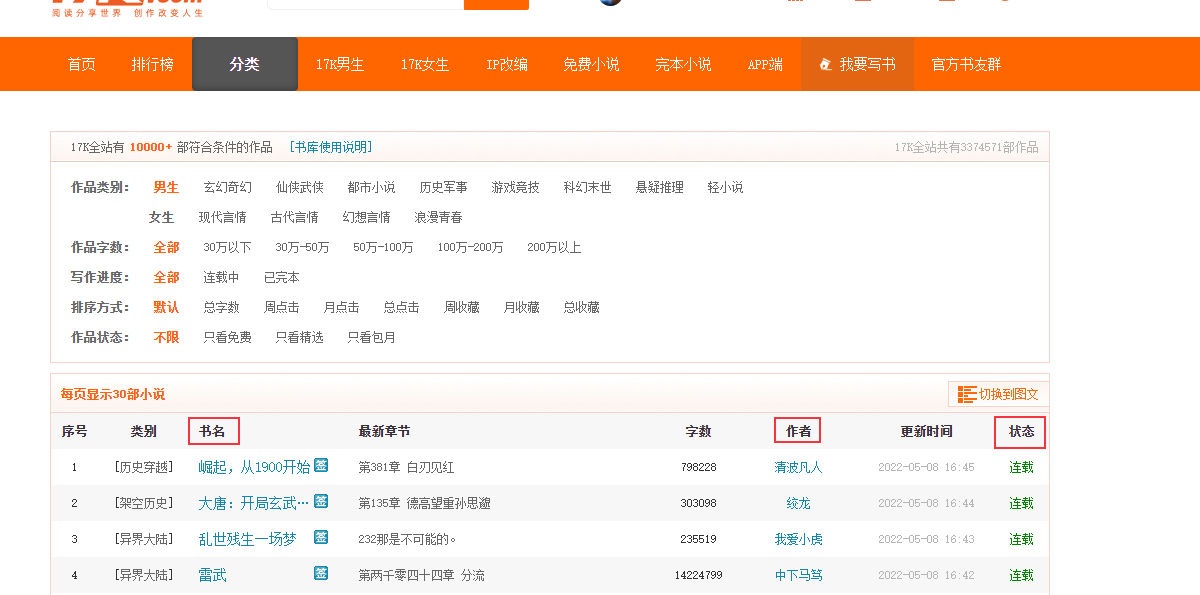

**一般写法**

分析：一般每一页的url除了页码的数字不同，其他都相同，需要观察每一页的url是否都有规律。在观察时多观察几页，有些网站第一页数据在源代码中，第二页数据就不一定在源代码中了。

观察该页面每一页的url，其数据都在源代码中，第一页的网址是`https://www.17k.com/all/book/2_0_0_0_0_0_0_0_1.html`,其他页的网址都只是改变了最后一个数字，最后一页的网址是`https://www.17k.com/all/book/2_0_0_0_0_0_0_0_334.html`,所以可以使用循环来创建拼接每一页的请求，获取数据。

爬虫代码：
```python
import scrapy


class FenyeSpider(scrapy.Spider):
    name = 'fenye'
    allowed_domains = ['17k.com']
    start_urls = ['http://17k.com/']  # 不使用默认的初始url，自己发送url，然后绑定回调函数

    # 1.重写，构造出每一页的请求，反馈Request对象
    def start_requests(self):
        # 2.页数总共是334页，拼接url
        for i in range(1, 3):  # 335，测试的时候改为10，防止将网页搞崩
            url = f'https://www.17k.com/all/book/2_0_0_0_0_0_0_0_{i}.html'
            yield scrapy.Request(
                url=url,
                method='GET',
                callback=self.parse  # 在parse回调中解析每一页需要的数据
            )

    def parse(self, resp, **kwargs):
        # 解析每一页的数据
        # print(resp.text)
        trs = resp.xpath('//table/tbody/tr')
        for tr in trs:
            book_name = tr.xpath('./td[3]//a/text()').extract_first()
            author = tr.xpath('./td[6]//a/text()').extract_first()
            status = tr.xpath('./td[8]/em/text()').extract_first()
            if not status:
                continue
            print(book_name, author, status.replace('\n', '').replace(' ', ''))

```

拿到数据：
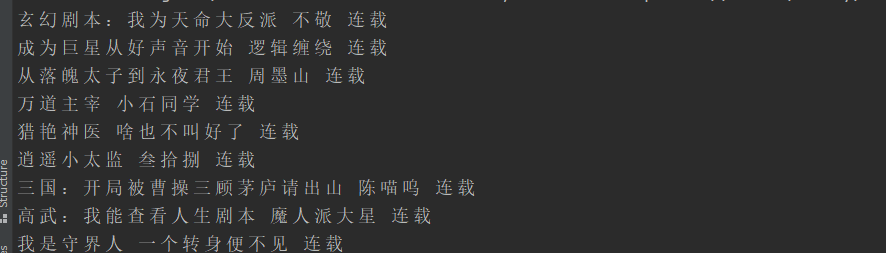

**比较scrapy的写法**

在拿到第一页的源代码，在源代码里有其他页码的链接，是除了当前页的最近其他几页的链接
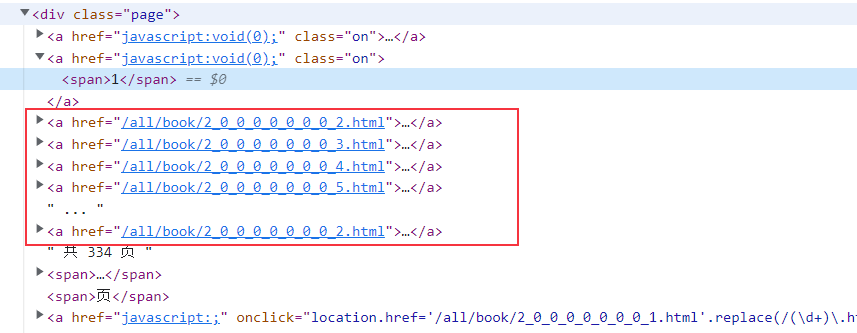

每一页我们拿到所有的页码链接，然后构造Request对象，返回给engine，由engine给调度器，先通过调度器的set去重，再加入调度器的队列中，等待engine的调度。

分析
- 当前页  源代码中其他页面    调度器中的页面对象
- 第一页    2，3，4，5，2     2，3，4，5
- 第二页    1，3，4，5，6     2，3，4，5，6
- 第三页    1，2，4，5，6，7   2，3，4，5，6，7
- 第n页      1-n           1，2，3...n

当将每一页源代码中的页面链接封装为Request对象给调度器后，调度器自动去重，从第二页开始往后，每次构造反馈多个Request对象，但是加进队列中的Request对象永远是下一页的请求对象，所以依次推下去，所有页面都能拿到。

**注意：**

在这样访问时，会拿到全部页码的数据，scrapy是协程，防止干崩网站，在settings.py中设置每次请求访问之后开启下一起请求的延迟时间：`DOWNLOAD_DELAY = 3`

也可以动态的设置访问延迟的间隔时间，在加上`RANDOMIZE_DOWNLOAD_DELAY = True`配置即可。

爬虫代码：
```python
import scrapy
from urllib.parse import urljoin

class Fenye2Spider(scrapy.Spider):
    name = 'fenye2'
    allowed_domains = ['17k.com']
    start_urls = ['https://www.17k.com/all/book/2_0_0_0_0_0_0_0_1.html']  # 初始url是第一页的url

    def parse(self, resp, **kwargs):
        # 解析一页中的数据
        trs = resp.xpath('//table/tbody/tr')
        for tr in trs:
            book_name = tr.xpath('./td[3]//a/text()').extract_first()
            author = tr.xpath('./td[6]//a/text()').extract_first()
            status = tr.xpath('./td[8]/em/text()').extract_first()
            if not status:
                continue
            print(book_name, author, status.replace('\n', '').replace(' ', ''))

        # 拿到源代码中其他页的链接，
        page_hrefs = resp.xpath("//div[@class='page']/a/@href").extract()
        for href in page_hrefs:
            if href.startswith('javascript'):
                continue
            # 其他页反馈给调度器，调度器自动去重
            yield scrapy.Request(
                url=urljoin(resp.url, href),
                method='GET',
                callback=self.parse  # 回调函数是本分，每次页面分析数据的代码是一样的
            )

```

代码执行分析：
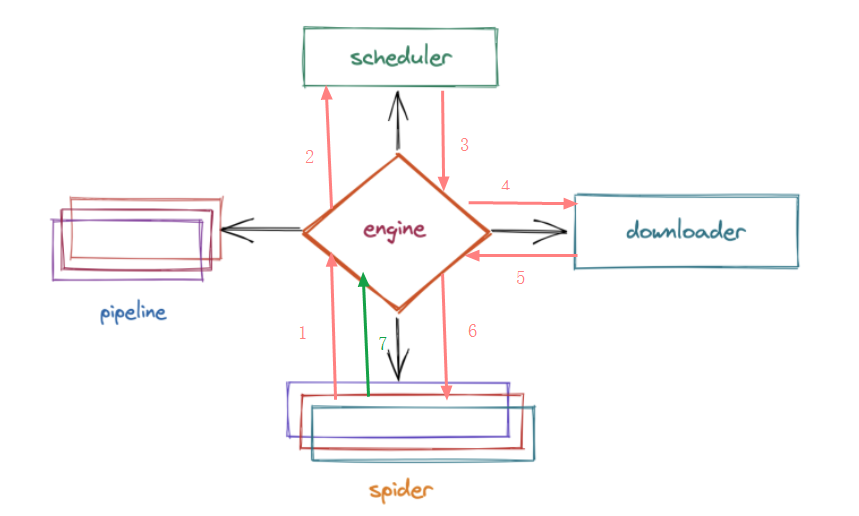

1. 第一页的Request给engine
2. engine给调度器
3. engine从调度器拿到一个Request
4. engine将请求给下载器下载
5. 下载器将Response对象返回给engine
6. engine将Response给spider进行页面的分析
7. 页面分析出有几个其他页的Request给引擎

重复步骤2-7，当最后一页的的源代码中的所有其他页的请求对象给调度器，但是最后一页拿到的源代码中的其他页封装成的Request对象，给调度器后，调度器会抛弃拿到的Request对象，因为，所有的页都已经加入到了调度器，所以此时程序就执行结束了，所有的页面都访问了一遍，这就是scrapy的分页，very 强大！！！

## 分页实战

网址：https://www.xiurenb.net/XiuRen/index8.html

1. 创建项目
`scrapy startproject mz_tu`

2. 生成spider `scrapy genspider xirenji xiurenb.net`

3. settings.py文件配置

```python
# Scrapy settings for mz_tu project
#
# For simplicity, this file contains only settings considered important or
# commonly used. You can find more settings consulting the documentation:
#
#     https://docs.scrapy.org/en/latest/topics/settings.html
#     https://docs.scrapy.org/en/latest/topics/downloader-middleware.html
#     https://docs.scrapy.org/en/latest/topics/spider-middleware.html

BOT_NAME = 'mz_tu'

SPIDER_MODULES = ['mz_tu.spiders']
NEWSPIDER_MODULE = 'mz_tu.spiders'
LOG_LEVEL = 'WARNING'


# Crawl responsibly by identifying yourself (and your website) on the user-agent
USER_AGENT = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36"

# Obey robots.txt rules
ROBOTSTXT_OBEY = False

# Configure maximum concurrent requests performed by Scrapy (default: 16)
#CONCURRENT_REQUESTS = 32

# Configure a delay for requests for the same website (default: 0)
# See https://docs.scrapy.org/en/latest/topics/settings.html#download-delay
# See also autothrottle settings and docs
#DOWNLOAD_DELAY = 3
# The download delay setting will honor only one of:
#CONCURRENT_REQUESTS_PER_DOMAIN = 16
#CONCURRENT_REQUESTS_PER_IP = 16

# Disable cookies (enabled by default)
#COOKIES_ENABLED = False

# Disable Telnet Console (enabled by default)
#TELNETCONSOLE_ENABLED = False

# Override the default request headers:
#DEFAULT_REQUEST_HEADERS = {
#   'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
#   'Accept-Language': 'en',
#}

# Enable or disable spider middlewares
# See https://docs.scrapy.org/en/latest/topics/spider-middleware.html
#SPIDER_MIDDLEWARES = {
#    'mz_tu.middlewares.MzTuSpiderMiddleware': 543,
#}

# Enable or disable downloader middlewares
# See https://docs.scrapy.org/en/latest/topics/downloader-middleware.html
#DOWNLOADER_MIDDLEWARES = {
#    'mz_tu.middlewares.MzTuDownloaderMiddleware': 543,
#}

# Enable or disable extensions
# See https://docs.scrapy.org/en/latest/topics/extensions.html
#EXTENSIONS = {
#    'scrapy.extensions.telnet.TelnetConsole': None,
#}

# Configure item pipelines
# See https://docs.scrapy.org/en/latest/topics/item-pipeline.html
ITEM_PIPELINES = {
   # 'mz_tu.pipelines.MzTuPipeline': 300,
   'mz_tu.pipelines.PicSave': 299,
}

# Enable and configure the AutoThrottle extension (disabled by default)
# See https://docs.scrapy.org/en/latest/topics/autothrottle.html
#AUTOTHROTTLE_ENABLED = True
# The initial download delay
#AUTOTHROTTLE_START_DELAY = 5
# The maximum download delay to be set in case of high latencies
#AUTOTHROTTLE_MAX_DELAY = 60
# The average number of requests Scrapy should be sending in parallel to
# each remote server
#AUTOTHROTTLE_TARGET_CONCURRENCY = 1.0
# Enable showing throttling stats for every response received:
#AUTOTHROTTLE_DEBUG = False

# Enable and configure HTTP caching (disabled by default)
# See https://docs.scrapy.org/en/latest/topics/downloader-middleware.html#httpcache-middleware-settings
#HTTPCACHE_ENABLED = True
#HTTPCACHE_EXPIRATION_SECS = 0
#HTTPCACHE_DIR = 'httpcache'
#HTTPCACHE_IGNORE_HTTP_CODES = []
#HTTPCACHE_STORAGE = 'scrapy.extensions.httpcache.FilesystemCacheStorage'

IMAGES_STORE = './mz_pic'

MEDIA_ALLOW_REDIRECTS = True
```

4. 爬虫代码编写

```python
import scrapy
from urllib.parse import urljoin


class XirenjiSpider(scrapy.Spider):
    name = 'xirenji'
    allowed_domains = ['xiurenb.net']
    start_urls = ['https://www.xiurenb.net/XiuRen/index8.html']  # 初始url，第一页的地址

    def parse(self, resp, **kwargs):
        # pages = resp.xpath("//div[@class='page'][1]/a/@href").extract()
        pages = resp.xpath("//div[@class='page']")[0]
        pages = pages.xpath(".//a/@href").extract()  # 页码中的所有页面的url
        # 解析详情页的链接
        li_list = resp.xpath("//ul[@class='update_area_lists cl']/li")  # 图集
        for li in li_list[0:1]:
            # 解析到当前页所有图集的地址，详情页由detail_parse来解析
            mz_name = li.xpath(".//*[@class='postlist-imagenum']//text()").extract_first()
            mz_href = li.xpath("./a/@href").extract_first()
            mz_href = urljoin(resp.url, mz_href)  # 图集详情页地址
            # print(mz_name,mz_href)
            yield scrapy.Request(
                url=mz_href,
                method='GET',
                callback=self.detail_parse
            )

        for page in [urljoin(resp.url, page_url) for page_url in pages][0:500]:  # 当前页中的所有其他页地址
            yield scrapy.Request(
                url=page,
                method='GET',
                callback=self.parse
            )

    def detail_parse(self, resp, **kwargs):
        # 解析详情页的信息，详情页也是有分页的，每个页面的处理逻辑一样

        # 解析出详情页的所有页码
        title = resp.xpath("//div[@class='item_title'][1]/h1/text()").extract_first()
        title = title.replace("[XiuRen秀人网]", "")
        print(title)
        # 解析图片src保存图片
        img_src = resp.xpath("//div[@class='content'][2]/p/img/@src").extract()
        for img_url in [urljoin(resp.url, img) for img in img_src]:
            # 保存图片
            yield {'title': title, 'img_src': img_url}

        # 其他页
        pages = resp.xpath("//div[@class='page']")[0]
        pages = pages.xpath(".//a/@href").extract()
        for page in (urljoin(resp.url, page_url) for page_url in pages):
            yield scrapy.Request(
                url=page,
                method='GET',
                callback=self.detail_parse
            )



```

5. 管道文件

```python
# Define your item pipelines here
#
# Don't forget to add your pipeline to the ITEM_PIPELINES setting
# See: https://docs.scrapy.org/en/latest/topics/item-pipeline.html


# useful for handling different item types with a single interface
from itemadapter import ItemAdapter
import os
import scrapy
from scrapy.pipelines.images import ImagesPipeline

class MzTuPipeline:
    def process_item(self, item, spider):
        print(item)
        return item


class PicSave(ImagesPipeline):
    def get_media_requests(self, item, info):
        url = item["img_src"]
        print("即将下载图片", item)
        yield scrapy.Request(
            url=url
        )

    def file_path(self, request, response=None, info=None, *, item=None):
        img_path = item['title']
        file_name = item['img_src'].split('/')[-1]
        real_path = os.path.join(img_path, file_name)
        return real_path

    def item_completed(self, results, item, info):
        for r in results:
            print("下载一张图片完成：", r[1].get("path"))
        return item

```